# fMRI and Machine Learning for Addiction Diagnosis
Using various machine learning algorithms to diagnose substance addiction from fMRI scans. <br>Dataset link: http://fcon_1000.projects.nitrc.org/indi/ACPI/html/acpi_nyu_1.html

**Part One:** Process fMRI data.

In [1]:
# Import libraries
import nilearn
import os
import nibabel as nib
from nilearn import image
from nilearn import datasets
import pandas as pd
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

C:\Users\mayap\Anaconda3\lib\site-packages\nilearn\datasets\__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# create probabilistic atlas
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas['maps']
labels = atlas['labels']
from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                         memory='nilearn_cache', verbose=5)

C:\Users\mayap\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [3]:
# function to convert fMRI scan to 
def fmri_to_mat(filepath):
    # create adjacency matrix
    data = nib.load(filepath)
    masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, memory='nilearn_cache', verbose=5)
    time_series = masker.fit_transform(data)
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    mat = np.matrix(correlation_matrix)
    return mat

In [ ]:
cocaine_matrices = [] 
path = r"C:\Users\mayap\ACSEF 2022\Data"
os.chdir(path)
for file in os.listdir(path):
    filename = os.fsdecode(file)
    cocaine_matrices.append(fmri_to_mat(filename))

In [ ]:
control_matrices = [] 
path = r"C:\Users\mayap\ACSEF 2022\Data2"
os.chdir(path)
for file in os.listdir(path):
    filename = os.fsdecode(file)
    control_matrices.append(fmri_to_mat(filename))

In [7]:
input_data = cocaine_matrices + control_matrices
labels = []
for num in range(56):
    labels.append(1)
for num in range(47):
    labels.append(0)

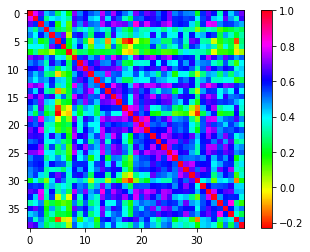

In [163]:
# Visualize a connectivity matrix
plt.set_cmap('hsv')
plt.imshow(input_data[0])
plt.colorbar()
plt.savefig(r"C:\Users\mayap\ACSEF 2022\matrix.png")
plt.show()

In [8]:
# shuffle data
import random
data = list(zip(input_data, labels))
random.shuffle(data)
input_data, labels = zip(*data)

In [143]:
# train/test split -- 80/20 ratio
xtrain = input_data[:82]
ytrain = list(labels[:82])
xtest = input_data[82:]
ytest = list(labels[82:])

In [144]:
# flatten each matrix and stack to create 2D input matrices
train_array = xtrain[0].flatten()
for item in xtrain[1:]:
    item = item.flatten()
    train_array = np.vstack((train_array, item))
# print(x_train[0])
test_array = xtest[0].flatten()
for item in xtest[1:]:
    item = item.flatten()
    test_array = np.vstack((test_array, item))
print(train_array.shape)

(82, 1521)


In [164]:
# create training, testing, and full dataframe and add labels
train_df = pd.DataFrame(train_array)
train_df['Label'] = ytrain
test_df = pd.DataFrame(test_array)
test_df['Label'] = ytest
df = pd.concat([train_df,test_df])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1512,1513,1514,1515,1516,1517,1518,1519,1520,Label
0,1.0,0.786501,0.677198,0.439709,0.496370,0.254489,0.390627,0.191283,0.714906,0.497016,...,0.174817,0.420234,0.447529,0.377330,0.150673,0.502203,0.246408,0.495943,1.0,1
1,1.0,0.827917,0.587555,0.500561,0.490929,0.131247,0.551486,0.456509,0.818154,0.107632,...,0.130054,0.257223,0.324194,0.271531,0.298920,0.330114,0.337357,0.634070,1.0,0
2,1.0,0.811054,0.637902,0.471006,0.643428,-0.221906,0.092366,0.633546,0.775126,0.442261,...,-0.249848,-0.108414,-0.309496,-0.207318,-0.269948,-0.078723,-0.203533,-0.173644,1.0,1
3,1.0,0.889251,0.765667,0.446490,0.631759,0.590747,0.428272,0.417469,0.834363,0.643253,...,0.320198,0.725862,0.692568,0.771089,0.667199,0.780083,0.644997,0.781264,1.0,0
4,1.0,0.482386,0.410157,0.413038,0.492561,0.300404,0.475965,0.030467,0.416407,0.656598,...,0.538464,0.043964,0.478359,0.244387,0.143131,0.286787,-0.012207,0.651094,1.0,1


In [136]:
# create training and testing variables
x_train = train_df.loc[:, train_df.columns != 'Label']
y_train = train_df['Label']
x_test = test_df.loc[:, test_df.columns != 'Label']
y_test = test_df['Label'].values.squeeze() # what does squeeze mean

# Machine Learning

Logistic Regression

In [169]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import seaborn as sns
class_rm = linear_model.LogisticRegression()
class_rm.fit(x_train,y_train)
y_pred = class_rm.predict(x_test)
y_pred = y_pred.squeeze()
y_prob = class_rm.predict_proba(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8095238095238095


C:\Users\mayap\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bagging Method (my lucky charm)

In [104]:
from sklearn.model_selection import KFold
kfold = KFold(3, True, 1)

C:\Users\mayap\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [114]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
bagging = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0)
x_train = train_df.loc[:, train_df.columns != 'Label']
y_train = train_df['Label']
x_test = test_df.loc[:, test_df.columns != 'Label']
y_test = test_df['Label'].values.squeeze()
bagging.fit(x_train,y_train)
pred_values = bagging.predict(x_test) 
acc = accuracy_score(y_test , y_pred)
print("Our accuracy scores:\n",acc)

Our accuracy scores:
 0.8095238095238095


In [110]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train,y_train)
clfp = clf.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.8095238095238095


Naive - Bayes classifier

In [133]:
X = df.loc[:, df.columns != 'Label']
y = df['Label']
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_train = sc.transform(X_test)
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, Y_train)
Y_pred  =  classifier.predict(X_test)
print(accuracy_score(Y_test,Y_pred))

0.6190476190476191


# Deep Learning

In [141]:
nnet = MLPClassifier(hidden_layer_sizes=(10), max_iter= 1000)  
nnet.fit(train_array, y_train)
predictions = nnet.predict(test_array)
print("MLP Testing Set Score:")
print(accuracy_score(y_test, predictions)*100)

MLP Testing Set Score:
76.19047619047619
